Methodologie INSEE :
- https://www.insee.fr/fr/metadonnees/source/operation/s2080/presentation
- https://www.insee.fr/fr/metadonnees/source/operation/s2226/presentation

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
# get the appropriate population
# The 'rp2021_td_pop1B_filtered.csv' file can be found here :
# https://www.insee.fr/fr/statistiques/8200787?geo=FE-1&sommaire=8200811

df_pop = pd.read_csv('../data/insee/rp2021_td_pop1B_filtered.csv', sep=";")
df_pop = df_pop.iloc[:, :-1]
# get only > 15 yold
P = df_pop.loc[3:20].Ensemble.sum()

In [3]:
df_pop

,Âge,Hommes,Femmes,Ensemble
0,Moins de 5 ans,1850788,1773371,3624159
1,5 à 9 ans,2064785,1975789,4040574
2,10 à 14 ans,2140562,2043740,4184302
3,15 à 19 ans,2141294,2022768,4164063
4,20 à 24 ans,1942538,1877303,3819841
5,25 à 29 ans,1884404,1916029,3800433
6,30 à 34 ans,1996915,2087571,4084485
7,35 à 39 ans,2063561,2159930,4223492
8,40 à 44 ans,2065219,2133839,4199058
9,45 à 49 ans,2188895,2236771,4425666


In [4]:
# get the average number of nights away
# corresponding file can be accessed here
# https://www.insee.fr/fr/statistiques/serie/010758184
df_nights_away = pd.read_csv('../data/insee/serie_010758184_01102025/valeurs_mensuelles.csv', sep=";")

In [5]:
# example for august 2020:
df_nights_away.loc[df_nights_away.Libellé=='2020-08']

,Libellé,Nombre de nuitées,Codes
61,2020-08,237.3,A


In [6]:
na_aug20 = float(df_nights_away.loc[df_nights_away.Libellé=='2020-08'].iloc[:,1].values[0])
na_aug20

237.3

In [7]:
# get the rate of travelers:
# corresponding file can be accessed here:
# https://www.insee.fr/fr/statistiques/serie/010758172
df_travelers = pd.read_csv('../data/insee/serie_010758172_01102025/valeurs_mensuelles.csv', sep=";")

In [8]:
# example for august 2020:
df_travelers.loc[df_travelers.Libellé=='2020-08']

,Libellé,Taux de départ en voyages (%),Codes
61,2020-08,45,A


In [9]:
travelers_2020 = float(df_travelers.loc[df_travelers.Libellé=='2020-08'].iloc[:,1].values[0])
travelers_2020

45.0

In [10]:
# lets consider the travelling period ranges from june to october
interval = ['2020-06', '2020-07', '2020-08', '2020-09', '2020-10']
df_nights_away.loc[df_nights_away.Libellé.isin(interval)]

,Libellé,Nombre de nuitées,Codes
59,2020-10,66.2,A
60,2020-09,87.9,A
61,2020-08,237.3,A
62,2020-07,131.5,A
63,2020-06,52.2,A


In [11]:
# lets consider the travelling period ranges from july to august, as the other months are far too uncertain
# to assess because the incoming flux should be taken into account as well and is not as easy to access
# on the other hand, it is reasonable to assume that people living in IDF will take a leave at summer, especially considering
# lockdown was going on months before  
interval = ['2020-07', '2020-08']
df_travelers.loc[df_travelers.Libellé.isin(interval)]

,Libellé,Taux de départ en voyages (%),Codes
61,2020-08,45,A
62,2020-07,34,A


In [12]:
# next, we can assume that french behavior w.r.t holidays is scheduled week in, week out, starting on saturdays
# for "july", we can consider the interval '2020-06-27' -> '2020-08-02'
# for "august", we can consider '2020-08-01' -> '2020-09-05'

In [13]:
(pd.to_datetime('2020-08-02') - pd.to_datetime('2020-06-27')).days

36

In [14]:
(pd.to_datetime('2020-09-05') - pd.to_datetime('2020-08-01')).days

35

In [15]:
# this leads to 36 days for 'july' and 35 for "august'

In [16]:
(45/35) * 7

9.0

In [17]:
(34/36) * 7

6.611111111111111

In [18]:
# on average, 9% of the population is leaving each week on august, and 6.6% on july
# we now have to take into consideration the average holiday duration
# according to a recent survey, it is around 2.1 weeks (https://www.ipsos.com/fr-fr/vacances-dete-les-projets-des-francais-entre-contraintes-et-desirs)
# we can round it to 2 weeks, and affect the corresponding schedule

In [19]:
# generating dates vector:
nsteps = 366
dates = []
dates.append(pd.to_datetime('2020-01-01'))

for i in range(1,nsteps):
    dates.append(dates[0] + datetime.timedelta(days=i))

In [20]:
pop_evolution = pd.DataFrame()
pop_evolution['dateStart'] = dates
pop_evolution['traveling_factor'] = 0.0

In [21]:
# july interval
july_proportion = 6.6
august_proportion = 9.0

# first week of july, 6.6% have left
first_date, end_date = '2020-06-27', '2020-07-03'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = july_proportion

# second week, another 6.6% have left, and the first week is still off
first_date, end_date = '2020-07-04', '2020-07-10'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = july_proportion + july_proportion

# third week, another 6.6% have left, the first week have come back, the second week is still off, etc.
first_date, end_date = '2020-07-11', '2020-07-17'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = july_proportion + july_proportion


first_date, end_date = '2020-07-18', '2020-07-24'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = july_proportion + july_proportion


first_date, end_date = '2020-07-25', '2020-08-02'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = july_proportion + july_proportion

In [22]:
# july interval
#first_date, end_date = '2020-06-27', '2020-08-02'

# first week of august, 6.6% of the last week of july + 9% of the first week of august
first_date, end_date = '2020-08-01', '2020-08-07'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = july_proportion + august_proportion

# second week of august, 9.0 + 9.0, etc
first_date, end_date = '2020-08-08', '2020-08-14'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = august_proportion + august_proportion

first_date, end_date = '2020-08-15', '2020-08-21'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = august_proportion + august_proportion

first_date, end_date = '2020-08-22', '2020-08-28'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = august_proportion + august_proportion

# this is the last week of people that went on holidays on '2020-08-22'
first_date, end_date = '2020-08-29', '2020-09-06'
pop_evolution.loc[(pop_evolution.dateStart>=first_date)&(pop_evolution.dateStart<=end_date), 'traveling_factor'] = august_proportion 

In [23]:
# to precisely account for travelling prior to first lockdown, we need to get
# the proportion of the population of each department

prop_94 = 1195223 / 2452889
prop_92 = 189531 / 2452889
prop_91 = 886425 / 2452889
prop_7877 = 181170 / 2452889

prop_7877 + prop_91 + prop_92 + prop_94 

0.9997798514323315

In [24]:
# now taking into account travelling before first lockdown:
fl_sd, fl_ed = pd.to_datetime('2020-03-17'), pd.to_datetime('2020-05-10')
# roughly 49% Val-de-Marne, 36% Essonne and 20% Hauts de Seine
# corresponding factors are taken from INSEE mobility data, available here:
# https://www.insee.fr/fr/statistiques/4635407
lockdown_factor = (prop_94*1.5 + prop_91*1.8 + prop_92*4.3 + prop_7877*2.0)
pop_evolution.loc[(pop_evolution.dateStart>=fl_sd)&(pop_evolution.dateStart<=fl_ed), 'traveling_factor'] = lockdown_factor
lockdown_factor

1.8613654347995363

In [25]:
# we now need to gather the nominal population
# then account for possible civil engineering
# and finally put everything together

In [26]:
# using area proportion approach, the nominal population according to INSEE 2020 data is 2452889
pop_evolution['nominal_population'] = 2452889

In [27]:
# Civil engineering reported situations:
# from '2020-01-01' to '2020-09-02' included, nominal situation
# from '2020-09-16' to '2020-09-23' included, situation2
# from '2020-09-28' to '2020-11-08' included, situation3
# from '2020-11-09' to '2020-11-11' included, situation4
# on '2020-12-09', situation5

In [28]:
pop_evolution.loc[(pop_evolution.dateStart>='2020-09-16')&(pop_evolution.dateStart<='2020-09-23'), 'nominal_population'] = 2600000
pop_evolution.loc[(pop_evolution.dateStart>='2020-09-28')&(pop_evolution.dateStart<='2020-11-08'), 'nominal_population'] = 1800000
pop_evolution.loc[(pop_evolution.dateStart>='2020-11-09')&(pop_evolution.dateStart<='2020-11-11'), 'nominal_population'] = 2200000
pop_evolution.loc[(pop_evolution.dateStart=='2020-12-09'), 'nominal_population'] = 1900000

In [29]:
pop_evolution['final_population'] = (1 - (pop_evolution['traveling_factor']/100)) * pop_evolution['nominal_population']

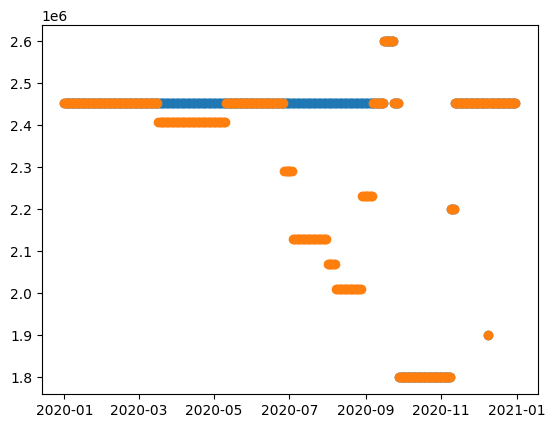

In [30]:
plt.scatter(pop_evolution.dateStart.values, pop_evolution.nominal_population.values)
plt.scatter(pop_evolution.dateStart.values, pop_evolution.final_population.values)

In [31]:
pop_evolution.to_csv('../outputs/files/census_pop/SEV_GT_manuscript.csv', sep=';', index=False)